Import

In [28]:
import pandas as pd
import numpy as np
import optuna
import catboost as cb
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from sklearn import metrics
import seaborn as sns

from fitting import  get_objective_Catboost, fit_CatBoost,generate_predictions

In [29]:
def import_data(file):
    """create a dataframe from a csv file"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    return df

df_train = import_data("input/train.csv")
df_allData = import_data("input/TDT4259-data.csv")

In [30]:
X_train, y_train = (df_train.drop(columns=['score']), np.log1p(df_train['score']))
x,y = (df_allData.drop(columns=['score']), np.log1p(df_allData['score']))

In [31]:
listKeep = x.columns.tolist()
print(listKeep)
for elem in listKeep:
    for col in x:
        if x[elem].corr(x[col]) > 0.9:
            if col in listKeep and col != elem:
                #print(elem, "made this one go", col)
                listKeep.remove(col)

print(listKeep)

X_train = X_train[listKeep]

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'numFix', 'numSac', 'ratioFixSac', 'meanPupil', 'sdPupil', 'meanFixDur', 'sdFixDur', 'meanSacVel', 'sdSacVel', 'meanSacAmp', 'sdSacAmp', 'scanpathVel', 'infoProcess', 'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r', 'bvpMean', 'bvpSD', 'edaMean', 'edaSD', 'hrMean', 'hrSD', 'tempMean', 'tempSD']


['V1', 'V7', 'V15', 'numFix', 'numSac', 'ratioFixSac', 'meanPupil', 'sdPupil', 'meanFixDur', 'sdFixDur', 'meanSacVel', 'sdSacVel', 'meanSacAmp', 'sdSacAmp', 'scanpathVel', 'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r', 'bvpMean', 'bvpSD', 'edaMean', 'edaSD', 'hrMean', 'hrSD', 'tempMean', 'tempSD']


In [32]:
X_train.head()

,V1,V7,V15,numFix,numSac,ratioFixSac,meanPupil,sdPupil,meanFixDur,sdFixDur,...,AU26_r,AU45_r,bvpMean,bvpSD,edaMean,edaSD,hrMean,hrSD,tempMean,tempSD
0,1.541903e+07,1.228252e+08,3.403192e+08,2801.000000,4862.000000,0.576100,3.519425,0.417162,202104.774723,159745.101029,...,0.159503,0.939242,6.717481,0.923533,0.055019,53.334402,84.861747,5.271920,32.930791,0.326669
1,2.407352e+09,6.114219e+07,1.355058e+09,3282.350499,5064.629057,0.598752,3.902360,0.313264,286075.859370,211208.213608,...,0.661913,0.660273,1.424132,0.927131,-0.005742,86.699887,78.807966,8.385079,26.639092,0.176392
2,4.179381e+07,2.706372e+07,6.494518e+07,2801.884425,4338.104655,0.793714,3.245197,0.289736,272756.098051,227273.254628,...,0.163666,0.916920,0.575160,0.096865,-0.001500,102.743248,77.250614,13.151015,26.853302,0.482578
3,4.940553e+08,4.672410e+08,4.954848e+09,2749.701764,3300.684733,0.866156,4.063874,0.328023,271614.741402,182867.021729,...,1.144854,0.376278,0.043954,0.018257,-0.004678,22.181033,68.077811,3.763305,29.940457,1.243421
4,2.803676e+08,5.605902e+08,2.604774e+09,3175.319702,4089.242820,0.700059,3.524979,0.341208,189912.673548,147709.515966,...,0.263805,0.134261,0.490070,0.108213,0.009162,84.512755,75.702971,8.577796,28.530812,0.221070


In [33]:
X_train.shape

(134, 40)

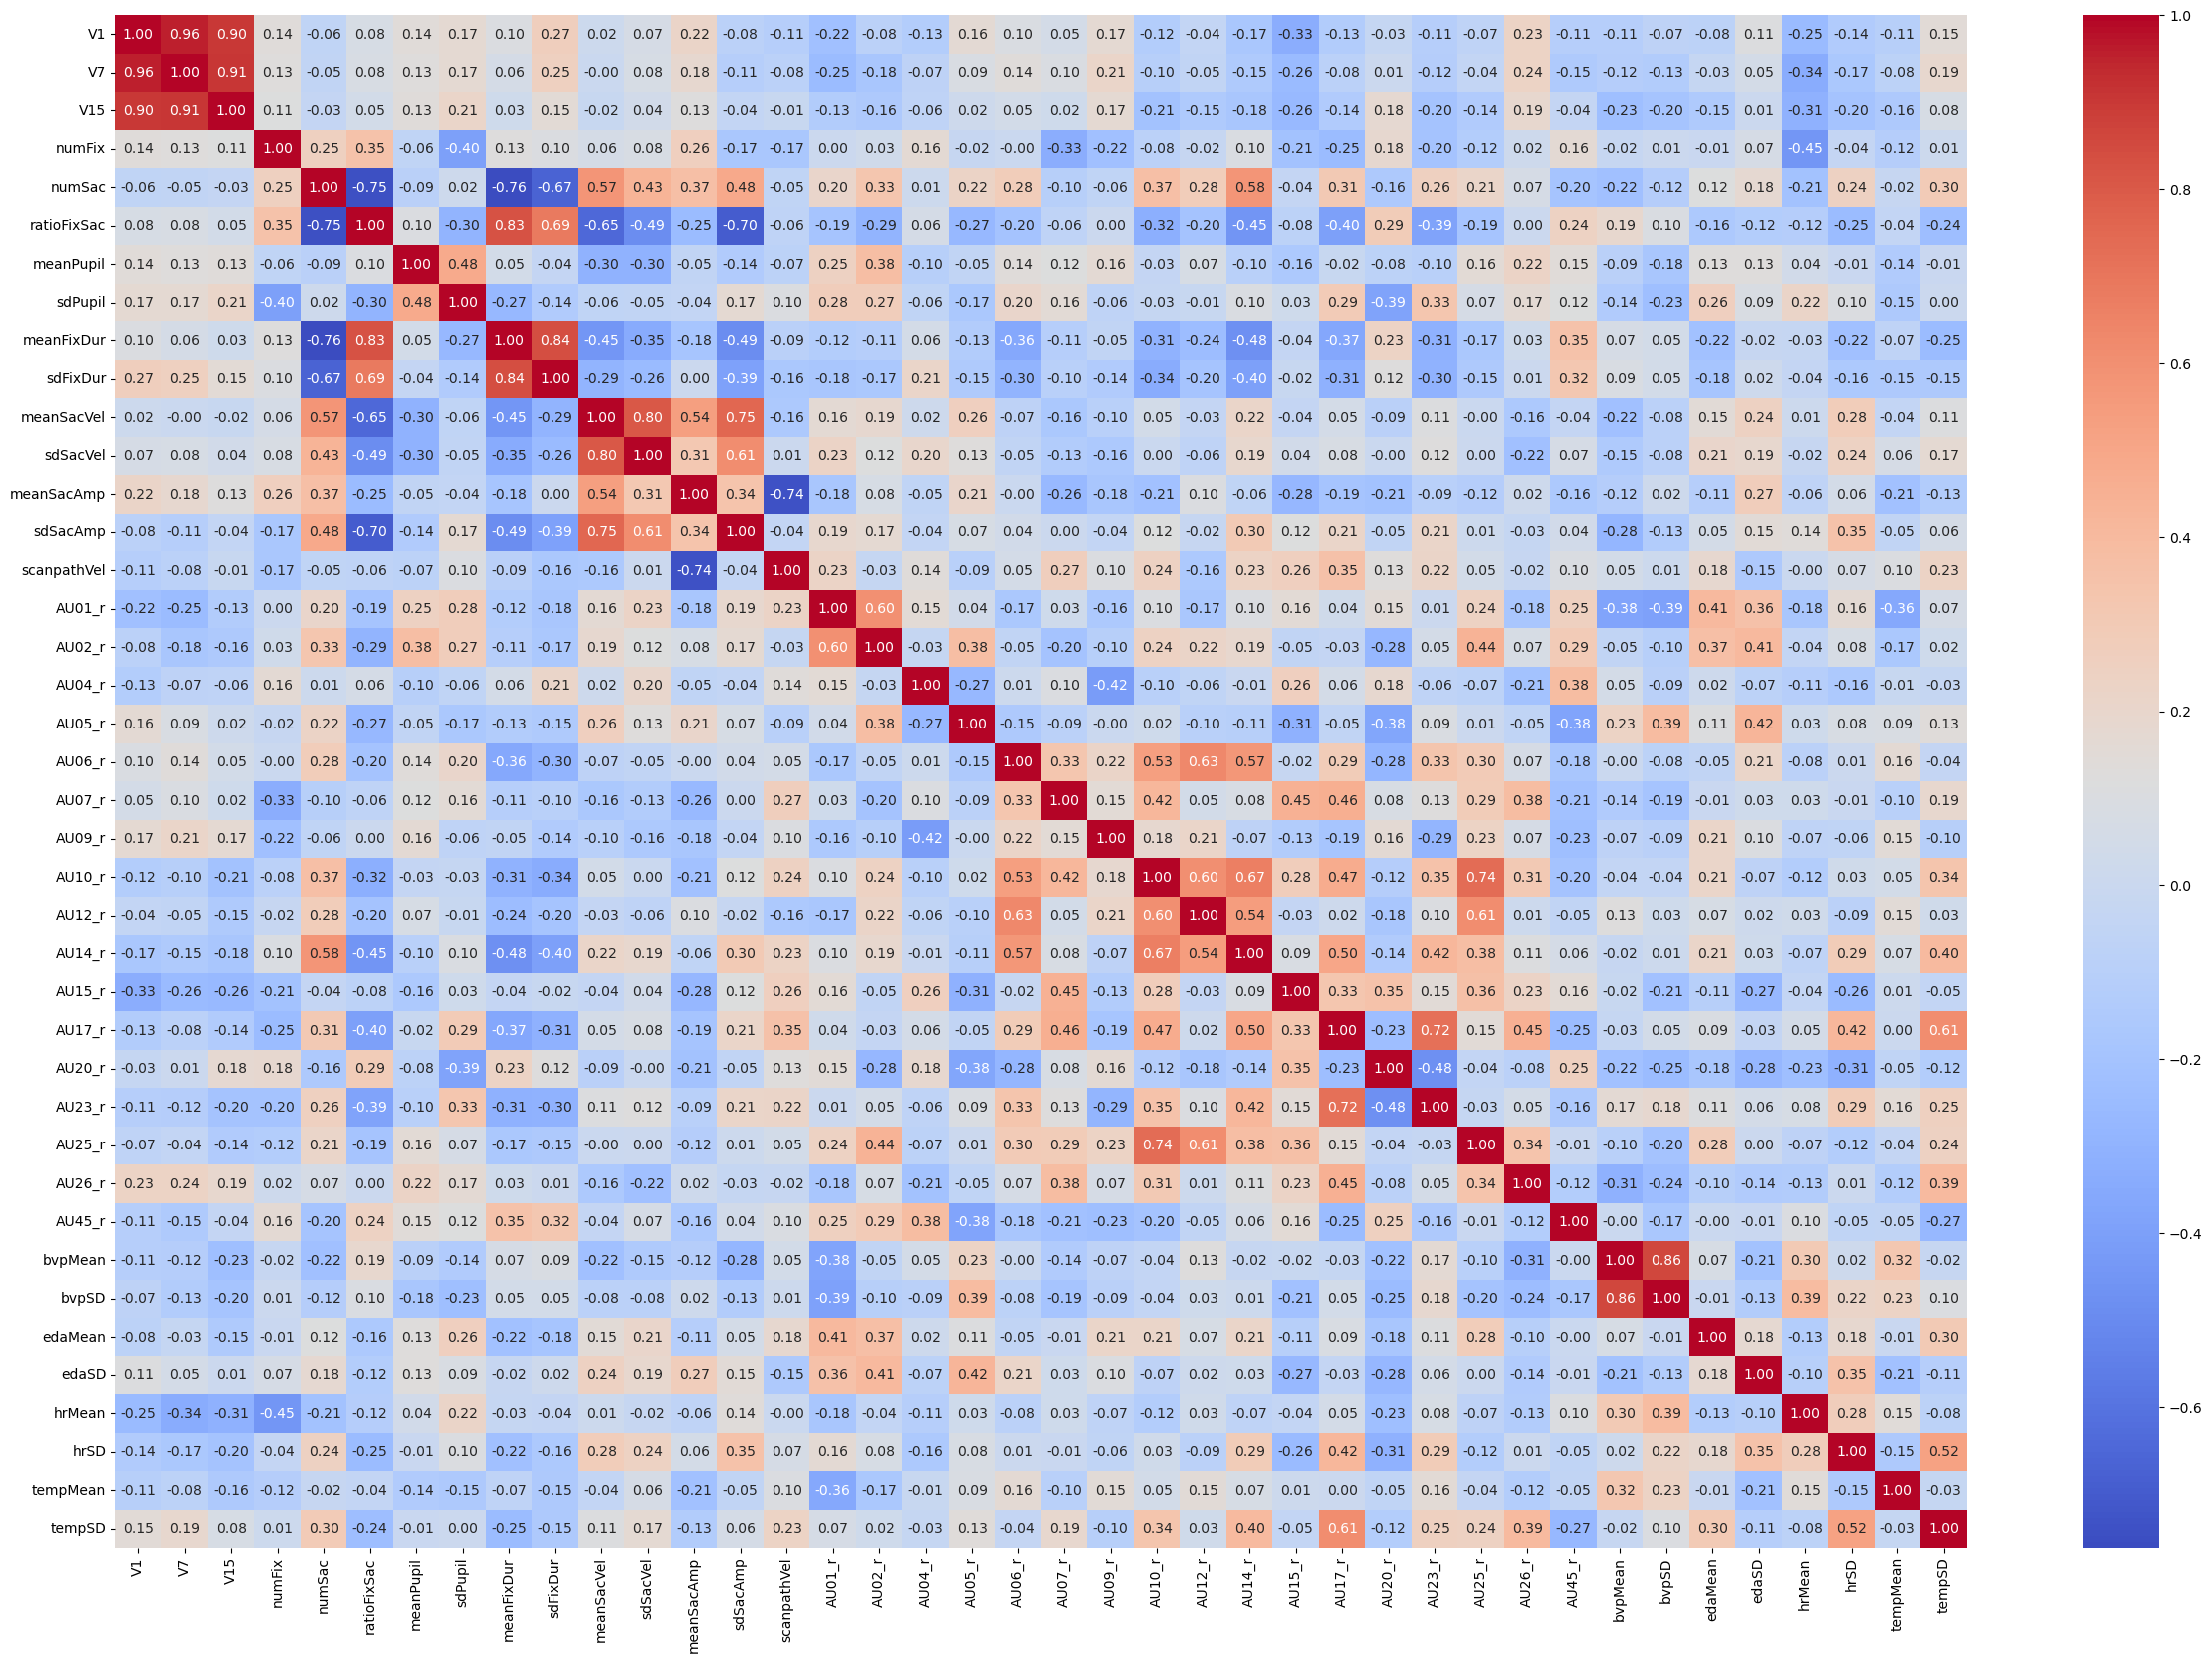

In [34]:
plt.figure(figsize=(30,20))
heatmap = sns.heatmap(X_train.corr(), annot=True, fmt=".2f", cmap="coolwarm")

Modelling

In [35]:
params = {'iterations': 530,
 'early_stopping_rounds': 38,
 'learning_rate': 0.053333529899705995,
 'depth': 6,
 'l2_leaf_reg': 80,
 'random_strength': 1.3806402421451422,
 'rsm': 0.505181534087604,
 'grow_policy': 'Depthwise',
 'sampling_frequency': 'PerTree',
 'min_data_in_leaf': 12,
 'border_count': 146,
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.37381073172705603}

In [36]:
if params is None:
    #This is timeconsuming code, and has already been run
    #The best parameters are already in the params variable
    objective = get_objective_Catboost(X_train, y_train)
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=10)
    trial = study.best_trial

In [37]:
mod = fit_CatBoost(params,X_train, y_train)

In [38]:
test= import_data("input/test.csv")
testX = test.drop(columns=['score'])
testX = testX[listKeep]
testy =test['score']

In [39]:
predictions = generate_predictions(mod, testX)

In [27]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(predictions, testy)
print(mse)

0.33588852295834676


Feature importance graphs

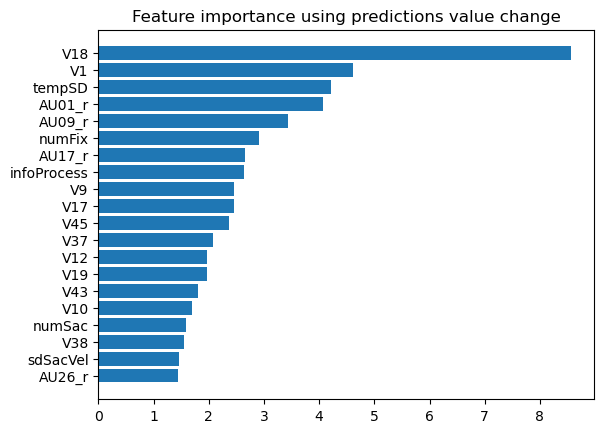

In [48]:
sorted_feature_importance = mod.feature_importances_.argsort()
top20features = sorted_feature_importance[-20:]
#plt.barh(X_train.columns[sorted_feature_importance], mod.feature_importances_[sorted_feature_importance])
plt.barh(X_train.columns[top20features], mod.feature_importances_[top20features])
plt.title("Feature importance using predictions value change")
plt.show()

Hjelpekode:

In [49]:
def log_loss(m, X, y): 
    return metrics.log_loss(y,m.predict_proba (X)[:,1])
    
def permutation_importances(model, X, y, metric):
    baseline = metric(model, X, y)
    imp = []
    for col in X.columns:
        save = X[col].copy()
        X[col] = np.random.permutation(X[col])
        m = metric(model, X, y)
        X[col] = save
        imp.append(m-baseline)
    return np.array(imp)

In [50]:
import shap

c:\Users\baryd\.conda\envs\TDT4173\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\baryd\.conda\envs\TDT4173\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_mask

In [51]:
def get_feature_imp_plot(method):
    
    if method == "Permutation":
        fi =  permutation_importances(mod, testX, testy, log_loss)
    

    
    elif method == "ShapeValues":
        shap_values = mod.get_feature_importance(cb.Pool(testX, label=testy), type="ShapValues")
        shap_values = shap_values[:,:-1]
        shap.summary_plot(shap_values, testX) 
        
    else:
        fi = mod.get_feature_importance(cb.Pool(testX, label=testy), type=method)
        
    if method != "ShapeValues":
        feature_score = pd.DataFrame(list(zip(testX.dtypes.index, fi )),
                                        columns=['Feature','Score'])

        feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

        plt.rcParams["figure.figsize"] = (12,7)
        ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
        ax.set_title("Feature Importance using {}".format(method), fontsize = 14)
        ax.set_xlabel("features")
        plt.show()

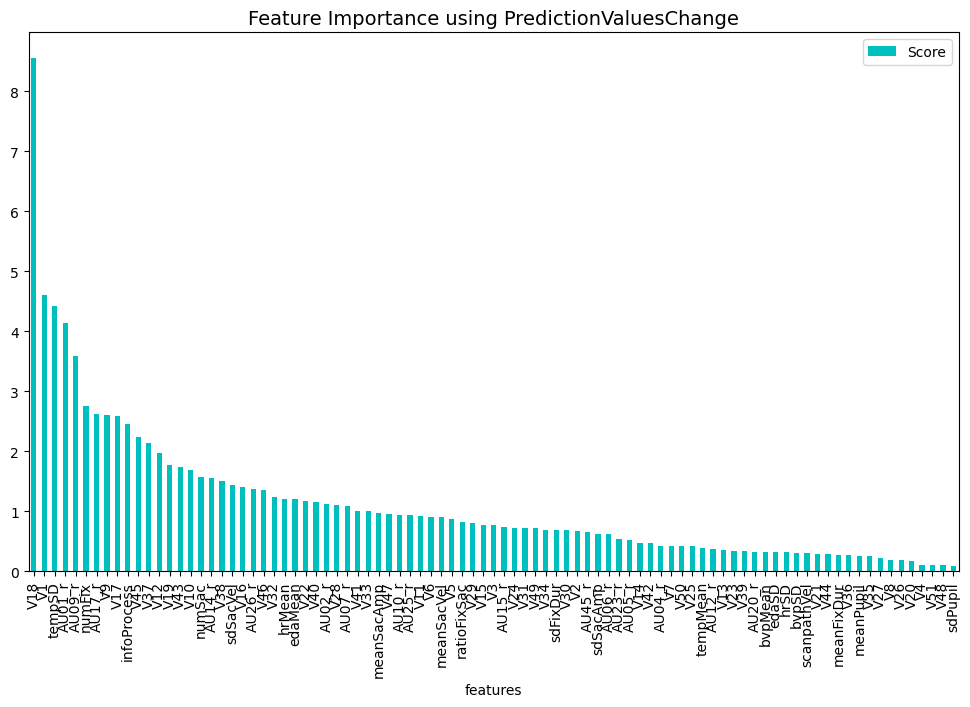

In [52]:
get_feature_imp_plot(method="PredictionValuesChange")

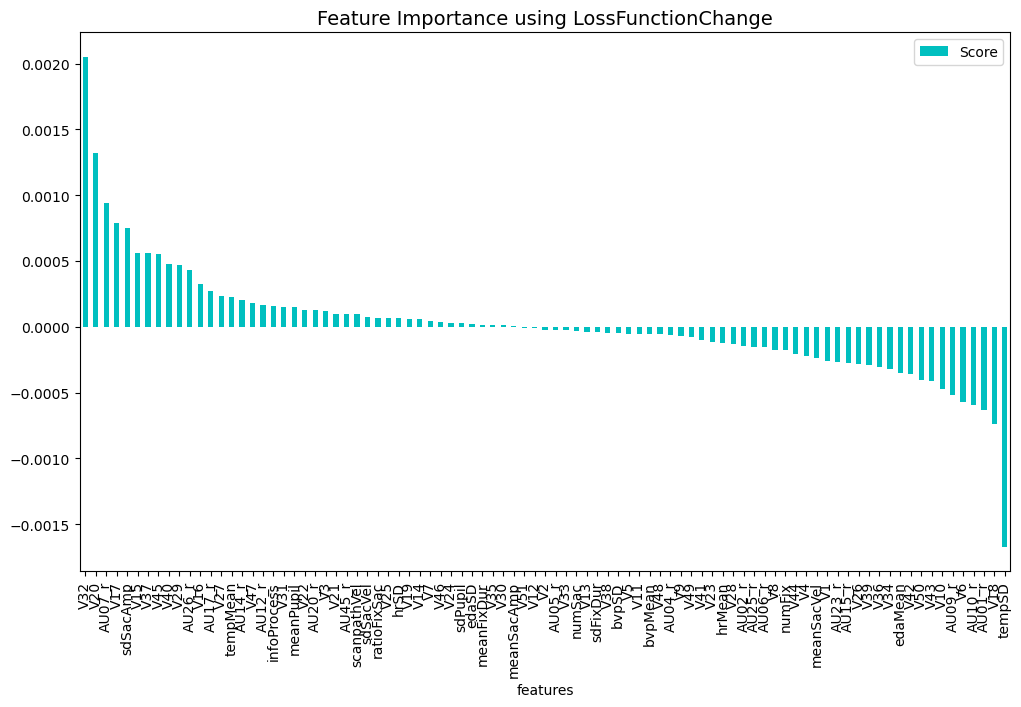

In [53]:
get_feature_imp_plot(method="LossFunctionChange")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


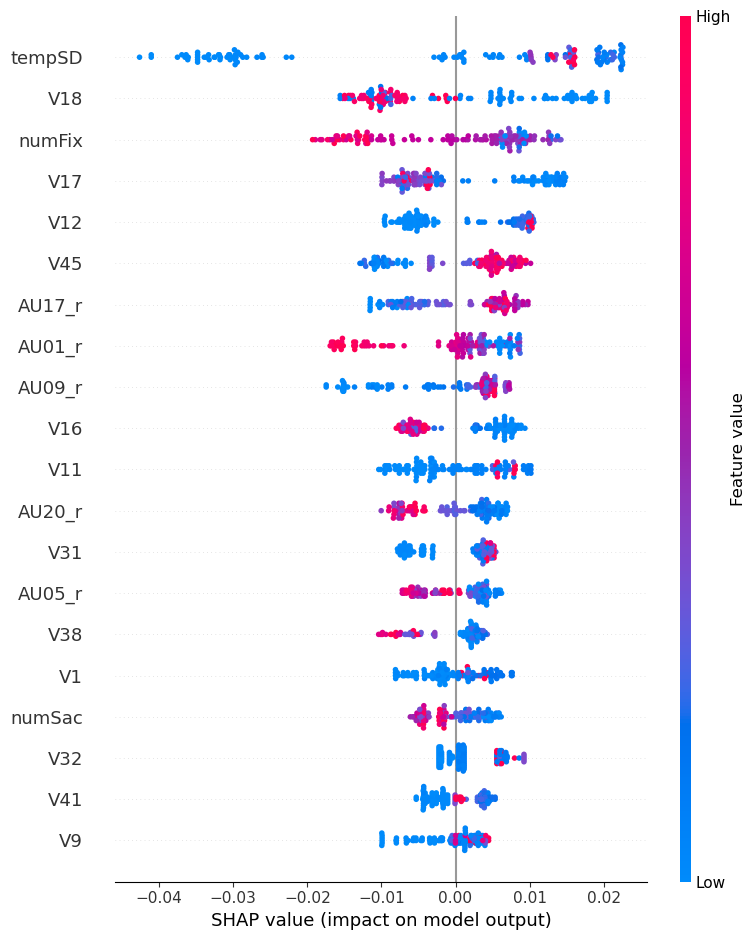

In [54]:
get_feature_imp_plot(method="ShapeValues")

Feature pair importance

In [55]:
fi = mod.get_feature_importance(cb.Pool(testX, label=testy), type="Interaction")

In [56]:
fi_new = []
for k, item in enumerate(fi):
    first = testX.dtypes.index[int(fi[k][0])]
    second = testX.dtypes.index[int(fi[k][1])]
    if first != second:
        fi_new.append([first + " | " + second, fi[k][2]])
    

In [61]:
fi_new[:5]

[['V15 | tempMean', 0.5589640304210328],
 ['AU02_r | AU12_r', 0.5156990131542522],
 ['V15 | AU02_r', 0.5112474689892568],
 ['V15 | AU12_r', 0.5112474689892568],
 ['V18 | tempSD', 0.49278518860062565]]

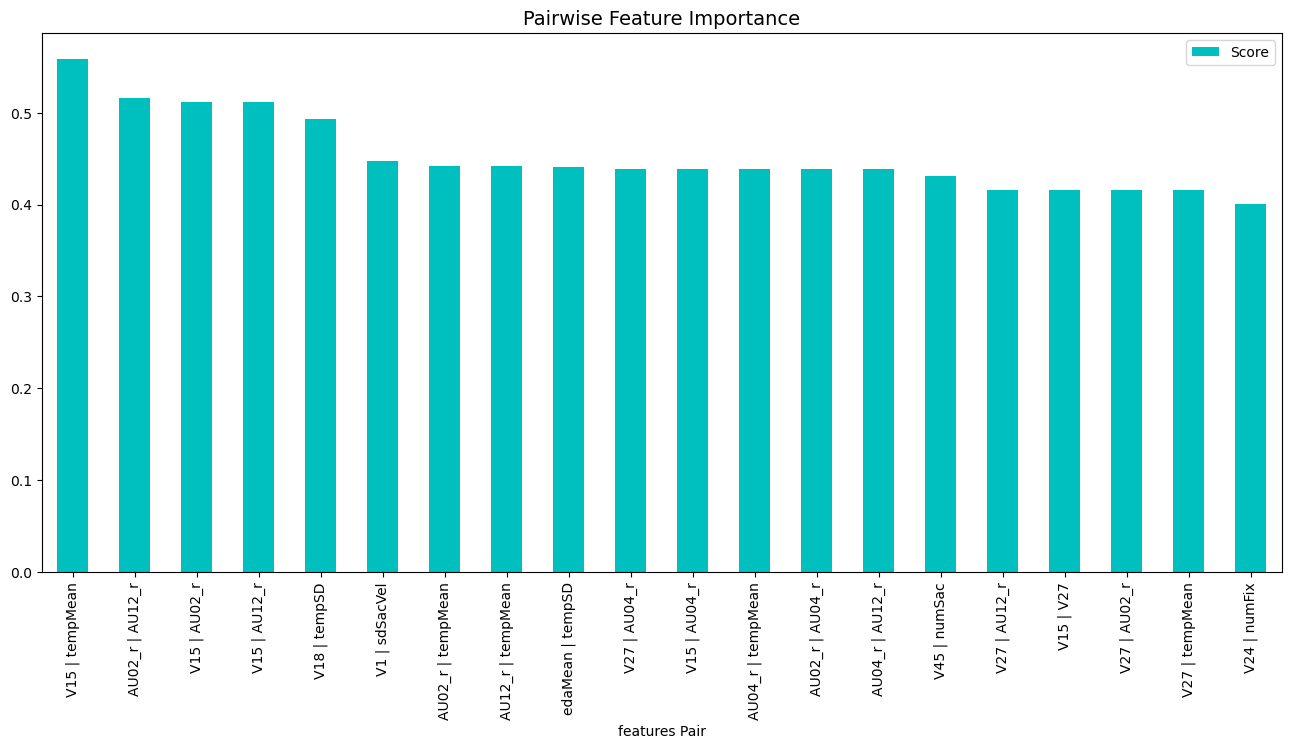

In [62]:
feature_score = pd.DataFrame(fi_new,columns=['Feature-Pair','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')[0:20]
plt.rcParams["figure.figsize"] = (16,7)
ax = feature_score.plot('Feature-Pair', 'Score', kind='bar', color='c')
ax.set_title("Pairwise Feature Importance", fontsize = 14)
ax.set_xlabel("features Pair")
plt.show()

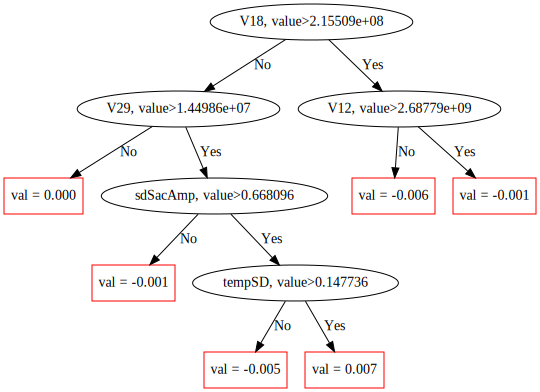

In [87]:
mod.plot_tree(tree_idx=0, pool=cb.Pool(testX, label=testy))